# import

In [2]:
import os
import pickle
from multiprocessing import Pool

import torch                                       # pytorch本体
import torch.nn as nn                              # ニューラルネットを構成する際の基本的なモジュールが入っている
import torch.optim as optim                        # ニューラルネットを最適化するためのoptimizerが入っている
from torchvision import transforms as transforms   # 画像前処理のために使用
import torchvision.transforms.functional as TF
import torchvision.models as models
import torch.nn.functional as F
import torch.utils.data
from torch.utils.tensorboard import SummaryWriter  # 学習ログのグラフ化のために使用

import logging                                     # ニューラルネットの学習ログをとるために使用
logger = logging.getLogger(__name__)               # ロガーの初期化

from tqdm import tqdm,trange                              # プログレスバーを出すために使用

import numpy as np
from PIL import Image                              # 画像を取り扱うために使用
import matplotlib.pyplot as plt                    # 画像のサンプル表示のために使用
import cv2
import cupy as cp

device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# dataのロードとdataloarderの作成

In [3]:
#ファイルのロード
sinogram_path="sinogram/sinogram_2410.npy"
sinogram=np.load(sinogram_path,allow_pickle=True)
sinogram_tensor=torch.tensor(sinogram).to(device)#tensor型に直す
print(sinogram_tensor.shape)

torch.Size([557, 371, 360])


In [6]:
#daaloarderの作成
batch_size=600 #ミニバッチのサイズを指定
target_dataloarder=torch.utils.data.DataLoader(sinogram_tensor.to(device),batch_size=batch_size,shuffle=False)#シャッフルは切っておく
predict_dataloarder=torch.utils.data.DataLoader(torch.zeros_like(sinogram_tensor),batch_size=batch_size,shuffle=False)#シャッフルは切っておく

dataloarders_dict={"target":target_dataloarder,"predict":predict_dataloarder}

# モデルとかの定義

In [7]:
#モデル
class ART(nn.Module):
    def __init__(self,sinogram):
        super(ART, self).__init__()  # これを追加
        self.device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.sinogram=sinogram #[N,Size,Angle]
        from torch_radon import Radon,Radon
        #ラドン変換の関数の初期化
        self.radon_func=Radon(resolution=371, angles=sinogram_tensor[0,0,:], det_count=- 1, det_spacing=1.0, clip_to_circle=False)
    
    #ラドン変換の関数の定義
    def A(self,tomography):
        return self.radon_func.forward(tomography)
    def AT(self,sinogram):
        return self.radon_func.backprojection(sinogram)
    
    #損失関数の定義
    def loss(self,predict,target):
        ATA=self.AT(self.A(torch.ones_like(target)))
        return torch.divide(self.AT(target - self.A(predict)), ATA)
    
    def forward(self,target,predict):
        loss=self.loss(predict,target)
        predict=predict+loss*0.1
        return predict,loss

# ループの関数
def trainer(model, dataloaders_dict, eps=1e-7):
    predict_dataloader = dataloaders_dict["predict"]
    target_dataloader = dataloaders_dict["target"]

    ave_loss = float("inf")
    
    predicted_list=[]

    for predict_batch, target_batch in zip(predict_dataloader, target_dataloader):
        predict_batch = predict_batch.to(model.device)
        target_batch = target_batch.to(model.device)
        iter=0
        while ave_loss > eps:
            predict_output, loss = model(target_batch, predict_batch)
            predict_batch = predict_output  # 予測を更新
            ave_loss = torch.mean(torch.abs(loss)).item()
            print(f'Iteration: {iter}, Loss: {ave_loss}') 
            iter+=1
        predicted_list.append(np.array(predict_batch.cpu()))
    return np.array(predicted_list)

In [8]:
model=ART(sinogram).to(device)
predicted_array=trainer(model,dataloarders_dict,eps=1e-10)
print(predicted_array.shape)

AssertionError: Input images must be square, got shape (371, 360).

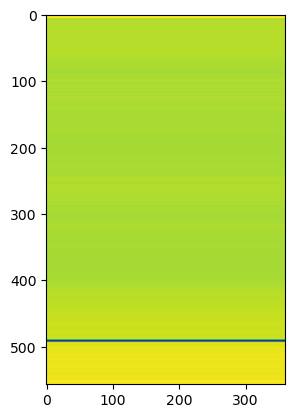

In [ ]:
plt.imshow(predicted_array[0,:,180,:])